In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch

## Load SMI data

Data source: https://data.snb.ch/de/topics/finma/cube/capchstocki?fromDate=2020-01-01&toDate=2024-12-22

In [4]:
raw = pd.read_csv("data/snb-data-pivoted-all-20241121_0900.csv", parse_dates=["Date"], index_col="Date")

# Strategy following Box-Jenkins

1. Data exploration & preparation
2. Analysis and modelling ARIMA component
3. Model heteroskedasticity using GARCH
4. Combining ARIMA and GARCH
5. Forecasting
6. Validation

## 1) Data exploration

### 1.1) Visualization and basic description of data

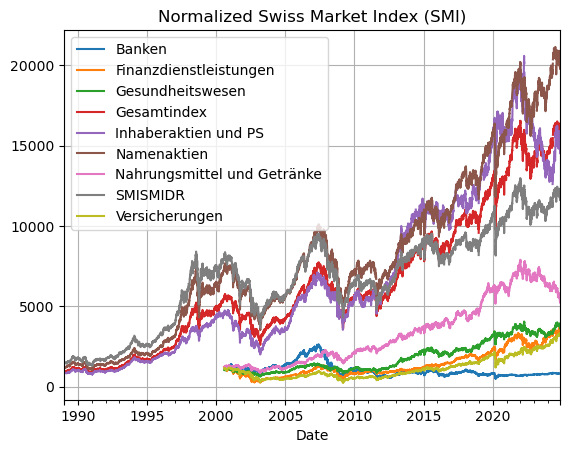

In [6]:
raw.plot(grid=True, title="Swiss Market Index (SMI)")
plt.show()

In the rest of this analysis, we shall focus on the overall index "Gesamtindex" only:

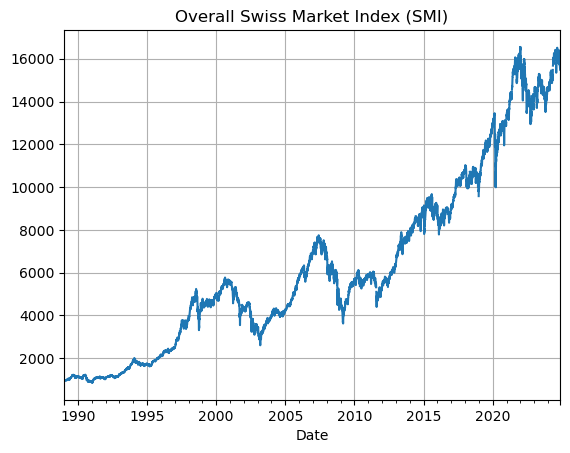

In [8]:
raw["Gesamtindex"].plot(grid=True, title="Overall Swiss Market Index (SMI)")
plt.show()

In [9]:
raw["Gesamtindex"].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 9360 entries, 1989-01-02 to 2024-11-15
Series name: Gesamtindex
Non-Null Count  Dtype  
--------------  -----  
9033 non-null   float64
dtypes: float64(1)
memory usage: 146.2 KB


From this we see that there are missing values. These we will need to handle later.

In [10]:
raw["Gesamtindex"].describe()

count     9033.000000
mean      6354.922799
std       4230.135638
min        843.500000
25%       3395.240000
50%       5451.590000
75%       8880.220000
max      16552.360000
Name: Gesamtindex, dtype: float64

### 1.2) Clean

First, handle the missing values by interpolating them linearly.

In [17]:
clean_data = raw["Gesamtindex"].interpolate()

Check if any missing values remain:

In [23]:
print(clean_data.isna().head())
print("No. of remaining missing values:", clean_data.isna().sum())

Date
1989-01-02     True
1989-01-03    False
1989-01-04    False
1989-01-05    False
1989-01-06    False
Name: Gesamtindex, dtype: bool
No. of remaining missing values: 1


Apparently, only one value is still missing. It could not be interpolated because it is the first value in the time series. We can simply drop this NaN-value without any relevant consequences. 

In [25]:
# Remove single remaining missing value
clean_data.dropna(inplace=True)

### 1.3) Check if data is stationary

A simple visual inspection is enough to demonstrate that the time series has a clear trend and thus is not stationary:

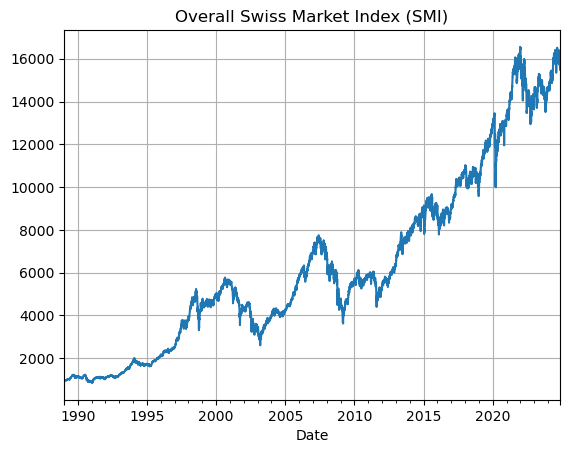

In [28]:
clean_data.plot(grid=True, title="Overall Swiss Market Index (SMI)")
plt.show()

However, we can use the augmented Dickey-Fuller test to confirm this in a quantitative approach:

In [34]:
adf = adfuller(clean_data)

print("Augmented DF results:")
print("---------------------")
print(f"ADF statistic: {adf[0]}")
print(f"p-value: {adf[1]}")

Augmented DF results:
---------------------
Statistic: 0.6125921277765215
p-value: 0.9879219258821984


The augmented Dickey-Fuller test returns a very large p-value, implying that we cannot reject the null-hypothesis saying that the time series is not stationary. This corresponds with the expectation based on the visiual inspection above.

However, the question remains, if the time series is stationary after differencing:

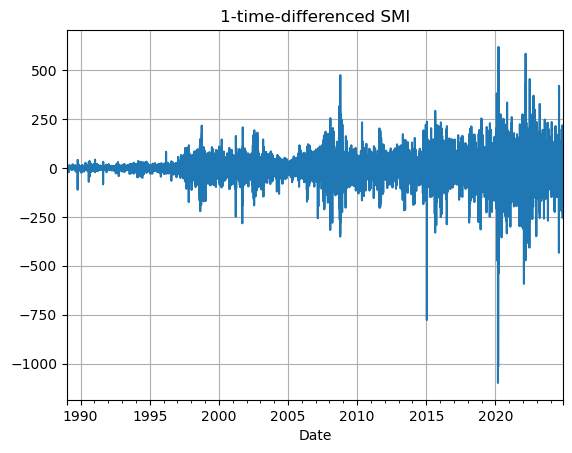

In [37]:
clean_data.diff().plot(grid=True, title="1-time-differenced SMI")
plt.show()

In [40]:
adf_diff = adfuller(clean_data.diff().dropna())

print("Augmented DF results:")
print("---------------------")
print(f"ADF statistic: {adf_diff[0]}")
print(f"p-value: {adf_diff[1]}")

Augmented DF results:
---------------------
ADF statistic: -17.859997418288692
p-value: 3.0559437669817933e-30


This result tells us that after differencing once, there is no left-over trend, the mean is constant and the original data is trend-stationary. However, the graphic suggests that the data is heteroskedastic.

In [48]:
arch_test = het_arch(clean_data.diff().dropna())

print("ARCH test results:")
print("---------------------")
print(f"ARCH statistic: {arch_test[0]}")
print(f"p-value: {arch_test[1]}")

ARCH test results:
---------------------
ARCH statistic: 2100.3119836938513
p-value: 0.0


The large value of the test statistic and the vanishing p-value confirm that there is strong heteroskedasticity present in the data.

### CONCLUSION: A simple ARIMA model is not enough to model this time series. We will have to model the variance explicitly using a GARCH approach.